### **Learning Objectives**
- Learn how to use different measurements in PennyLane.
- Understand the role of observables in measurements.

### PennyLane Measurements Cheat Sheet
Measurements in PennyLane are special. They provide flexibility, enabling you to perform measurements on both simulators and real quantum hardware. They also offer variety, allowing you to customize your quantum algorithms to your specific requirements. Let’s look into different PennyLane measurements and how you can use them to your advantage.

We will explore these measurements in the light of a simple, noiseless, two-qubit circuit where the first qubit is in the $\ket{0}$ state and the second in the $\ket{1}$ state. We will refer it as our `simple_circuit`

In [1]:
import pennylane as qml
from pennylane import numpy as np

(<Figure size 500x300 with 1 Axes>, <Axes: >)

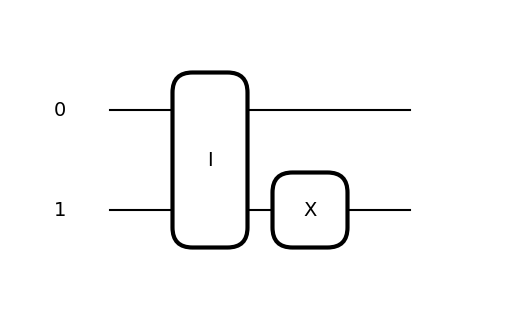

In [2]:
dev = qml.device("default.qubit", wires = 2)
@qml.qnode(dev)
def simple_circuit():
    qml.Identity(wires = [0])
    qml.X(wires = [1])
    # return my_measurement 
qml.draw_mpl(simple_circuit)()

The table below summarizes the measurements you could put in place of ``my_measurement``. Use it as a cheat sheet when you're already familiar with PennyLane measurements. However, if you’re looking to understand them in depth, make sure to read the relevant sections below.

| Measurement         | PennyLane function         | Output type | Requires `shots > 0` | Is differentiable* | Requires an observable | Example output                                         |
|---------------------|----------------------------|-------------|-----------------------|---------------------|------------------------|--------------------------------------------------------|
| Sample              | `qml.sample`               | Array       | Yes                   | No                  | No                     | `array([0, 1])`                                        |
| Counts              | `qml.counts`               | Dict        | Yes                   | No                  | No                     | `{'01': 1}`                                            |
| Probability         | `qml.probs`                | Array       | No                    | Yes                 | No                     | `array([0., 1., 0., 0.])`                              |
| Expectation value   | `qml.expval`               | Float       | No                    | Yes                 | Yes                    | `qml.expval(qml.Z(wires=0)), qml.expval(qml.Z(wires=1))`<br>`Out: (1.0, -1.0)` |


`Is differentiable` refers to the fact : 
Can this measurement be used in gradient-based optimization? 

In [3]:
# The use of `qml.sample`
device = qml.device("default.qubit", wires = 2, shots = 7)
@qml.qnode(device)
def entangled_state():
    qml.Hadamard(wires = [0])
    qml.CNOT(wires = [0,1])
    return qml.sample(wires = [0,1])
print(entangled_state())
# It means `qml.sample` returns the state on which our system collapse to, after measurement.

[[0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]]


We can also specify an observable in qml.sample. Let's say that, once again, we prepare the $\ket{+}$ state on one qubit and sample from the PauliX observable with ten shots. What result do we expect to obtain?

The $\ket{+}$ state is an eigenstate of the PauliX observable, where corressponding eigenvalue is 1. So we expect to obtain an array of 1s as an output.

In [4]:
device = qml.device("default.qubit", wires = 2, shots = 7)
@qml.qnode(device)
def entangled_state():
    qml.Hadamard(wires = [0])
    qml.CNOT(wires = [0,1])
    return qml.sample(qml.PauliX(0))
print(entangled_state())

[-1.  1. -1.  1.  1.  1. -1.]


What happens when you have hundreds or thousands of shots? If you measure samples, you’ll get hundreds or thousands of lines in your output, containing the eigenvalues measured for your observable. Unless you’re a machine (and if you are then please rank us high on Google search), it will be virtually impossible to analyze these very large outputs. The trick is to use `counts` to summarize this information. Counts will give us a dictionary with the number of occurrences (or counts) for each sample.

Let's look at the same example we used for qml.sample, but this time we use 1000 shots and measure qml.counts.

In [5]:
# The use of `qml.counts`
device = qml.device("default.qubit", wires = 2, shots = 1000)
@qml.qnode(device)
def entangled_state():
    qml.Hadamard(wires = [0])
    qml.CNOT(wires = [0,1])
    return qml.counts()
print(entangled_state())
# It means `qml.counts` returns how many times a state is appearing.

{np.str_('00'): np.int64(481), np.str_('11'): np.int64(519)}


We can do the same with an observable specified. Choosing `qml.PauliX` like before, we expect all outcomes to be 1, which indeed happens.

In [9]:
device = qml.device("default.qubit", wires = 1, shots = 10)
@qml.qnode(device)
def entangled_state():
    qml.Hadamard(wires = [0])
    return qml.counts(qml.PauliX(0))
print(entangled_state())

{np.float64(1.0): np.int64(10)}


In [7]:
# The use of `qml.probs`
device = qml.device("default.qubit", wires = 2, shots = 7)
@qml.qnode(device)
def entangled_state():
    qml.Hadamard(wires = [0])
    qml.CNOT(wires = [0,1])
    return qml.probs()
print(entangled_state())
# It means `qml.probs` returns the probability of each state to be measured

[0.42857143 0.         0.         0.57142857]


### Observables
Recall that an observable is an operator that represents the possible outcomes of a particular measurement on a quantum system. Namely,
- The eigenvalues $\lambda_{i}$ of the operator represent the values that the measurement outcome can have.
- The eigenstate $\ket{\lambda_{i}}$ associated to the eigenvalue $\lambda_{i}$ represents the state right after measurement.

Additionally, Bohr's Rule tells us that the probability of measuring the value $\lambda_{i}$ given a state $\ket{\psi}$ right before measurement is
$$
p(i) = |\langle \lambda_i | \psi \rangle|^2
$$
In PennyLane, observables are operators that are also Hermitian. For example, the PennyLane operators `qml.PauliX` and `qml.Hadamard` are also observables. We can create more general observables using Operator Arithmetic. For example, if we want to define the Hermitian operator
$$
O = \frac{1}{2} X \otimes X + \frac{1}{4} Y \otimes Y
$$
we write the script below

In [8]:
O = 1/2 * qml.X(0) @ qml.X(1) + 1/4 * qml.Y(0) @ qml.Y(1)

Here, the symbol @ denotes the tensor product between PennyLane operators, and the arguments 0 and 1 are the wires on which the operators X and Y act.

### Expectation Values

Expectation values are probably the most used type of measurement, especially for optimization and machine learning since they give useful information about the state and they’re differentiable (not stochastic)! Let's recall that for an observable represented by the operator $\hat{O}$ and a state $\ket{\psi}$ right before measurement, the expectation value $<\hat{O}>$ is calculated via, 

$$
<\hat{O}> = \langle \psi |\hat{O}| \psi \rangle
$$

What is the analytic expectation value of the PauliZ observable for the first qubit in our simple circuit? We expect it to be $<Z> = \langle 0|\hat{Z}|0 \rangle = 1$. We can code it in PennyLane to check this is indeed the case.

In [16]:
@qml.qnode(dev)
def simple_circuit():
    qml.Identity(wires = [0])
    qml.X(wires = [1])
    return qml.expval(qml.PauliZ(0)) 
print(simple_circuit())

1.0


Note that `qml.expval` only takes an observable as an argument. The wires are specified in the observable itself. Let's look at another example with a more complicated observable.

In [17]:
@qml.qnode(dev)
def expval_circuit():
    
    qml.RY(np.pi/4, wires = 0)
    qml.RX(np.pi/3, wires = 1)
    qml.CNOT(wires = [0, 1])
    
    return qml.expval(1/3*qml.PauliZ(0) @ qml.PauliZ(1))


expval_circuit()

np.float64(0.16666666666666669)

Did you know PennyLane can return multiple measurements at once? Of course! The output will be a tuple with the corresponding results for each measurement. For instance, if we want to measure the analytic expectation value of the PauliZ observable for both qubits in our simple circuit, we can code it as `qml.expval(qml.Z(wires=0))`, `qml.expval(qml.Z(wires=1))`. The output will be a tuple (1.0, -1.0). We can also combine different types of measurements. Give it a try!

In [32]:
@qml.qnode(dev)
def simple_circuit():
    qml.Identity(wires = [0])
    qml.X(wires = [1])
    return qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(0))
simple_circuit()

(np.float64(-1.0), np.float64(1.0))

##### **Problem** : Calculate the expectation value of any hermition observable which is not defiend as a built-in gate or observable in pennylane.
In PennyLane you can represent an arbitrary Hermitian observable by using `qml.Hermitian`.

Why is this useful? Calculating the expectation value of a Hermitian matrix A can be useful for obtaining information such as the fidelity between A and the state of the circuit upon measurement. Note: using qml.Hermitian together with qml.probs is not supported.

In [33]:
# lets define the observable
Observable = np.array([
    [1,0],
    [0,-1]
])
@qml.qnode(dev)
def any_func():
    qml.Hadamard(wires = 0)
    qml.CNOT(wires = [0,1])
    return qml.expval(qml.Hermitian(Observable, wires = [1]))
print(any_func())


0.0


**Problem** : Compute the probability of the tensor $<Z_{0} \otimes Z_{1}>$.

In [41]:
dev = qml.device("default.qubit", wires = 2)
@qml.qnode(dev)
def function():
    qml.Hadamard(wires = [0])
    qml.CNOT(wires = [0,1])
    return qml.probs(op = qml.Z(wires = 0) @ qml.Z(wires = 1))
print(function())

[0.5 0.  0.  0.5]
